<h2>HW 4: Empirical Risk Minimization</h2>


<h3>Introduction</h3>

<p>
    In this project you will be building an email spam filter.</p>




<h3>Computing derivatives</h3>

<p>  Before you dive into the programming part of this assignment you will need to derive the gradients for several loss functions. 
    <b>Please write your calculation in a comment block within your code.</b> 
</p>

<p>   Derive the gradient function for each of the following loss functions with respect to the weight vector $w$. Write down the gradient update (with stepsize $c$). <br>
(Note that:    $\|w\|_2^2=w^\top w$ and  $\lambda$ is a  non-negative constant.)
</p>

<ol>
    <li> Ridge Regression: ${\cal L}(w)=\frac{1}{n}\sum_{i=1}^n (w^\top x_i-y_i)^2+\lambda \|w\|_2^2$ </li>
    <li> Logistic Regression: ($y_i\in\{+1,-1\}$): ${\cal L}(w)=\sum_{i=1}^n \log(1+\exp{(-y_i w^\top x_i)})$ </li>
    <li> Hinge loss: ($y_i\in\{+1,-1\}$): ${\cal L}(w)=\sum_{i=1}^n \max \left(1-y_i(w^\top x_i+b),0\right)+\lambda \|w\|_2^2$ </li>
</ol>  

<h3>Building an email spam filter</h3>
<p> You will now implement ridge loss and the Adagrad algorithm.
   
The function below loads in pre-processed email data, where emails are represented as bag-of-words vectors.
</p>


In [1]:
import pandas as pd
import numpy as np

In [3]:
emails = pd.read_csv('/content/spam.csv')
emails.head()

,Label,EmailText
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#<GRADED>
import numpy as np
#</GRADED>
import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import sys
from scipy.io import loadmat
import time

%matplotlib inline

In [5]:
# tokenize the email and hashes the symbols into a vector
def extractfeaturesnaive(email, B):
    # initialize all-zeros feature vector
    v = np.zeros(B)
    
    # breaks for non-ascii characters
    tokens = email.split()
    for token in tokens:
        v[hash(token) % B] = 1
    return v

def loadspamdata(extractfeatures, train_data, B=512):
    '''
    INPUT:
    extractfeatures : function to extract features
    B               : dimensionality of feature space
    path            : the path of folder to be processed
    
    OUTPUT:
    X, Y
    '''
    
    xs = np.zeros((len(train_data), B))
    ys = np.zeros(len(train_data))
    for i, email_sample in train_data.iterrows():
        # make labels +1 for "spam" and -1 for "ham"
        ys[i] = (email_sample['Label'] == 'spam') * 2 - 1
        xs[i, :] = extractfeatures(email_sample['EmailText'], B)
    print('Loaded %d input emails.' % len(ys))
    return xs, ys

X,Y = loadspamdata(extractfeaturesnaive, emails)
X.shape

Loaded 5572 input emails.


(5572, 512)

In [6]:
emails.iloc[0]['EmailText']

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

This is your training set. To evaluate your algorithm you should split it off into a validation set.

In [7]:
# Split data into training and validation
n, d = X.shape
cutoff = int(np.ceil(0.8 * n))
# indices of training samples
xTr = X[:cutoff,:]
yTr = Y[:cutoff]
# indices of testing samples
xTv = X[cutoff:,:]
yTv = Y[cutoff:]

<p>This should generate a training data set <code>xTr</code>, <code>yTr</code> and a validation set <code>xTv</code>, <code>yTv</code> for you. </p>

<p>It is now time to implement your classifiers. We will always use the Adagrad gradient descent algorithm, but with various loss functions. 
First implement the function <code>ridge</code> which computes the ridge regression loss and gradient for a particular data set <code>xTr</code>, <code>yTr</code> and a weight vector <code>w</code>. Make sure you don't forget to incorporate your regularization constant $\lambda$. </p>

In [9]:

def ridge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    ## fill in your code here
    #raise NotImplementedError('Your code goes here!')
    diff = xTr.dot(w) - yTr    
    
    loss = diff.T.dot(diff) / n + lmbda * w.dot(w)
    
    grad = (xTr.T.dot((xTr.dot(w) - yTr)) * 2 / n + 2 * lmbda * w)
    
    return loss, grad
    

<p>An  alternative to  deriving the gradient analytically is to estimate it numerically. This is very slow, but it is a convenient  way to check your code for correctness.  The following function  uses numerical differentiation to evaluate the correctness of ridge.  If your code is correct, the norm difference between the two should be very small (smaller than $10^{-8}$). 
Keep in mind that this only checks if the gradient corresponds to the loss, but not if the loss is correct. The function also plots an image of the gradient values (blue) and their estimates (red). If everything is correct, these two should be right on top of each other.
</p>

The norm ratio is 0.0000000004.


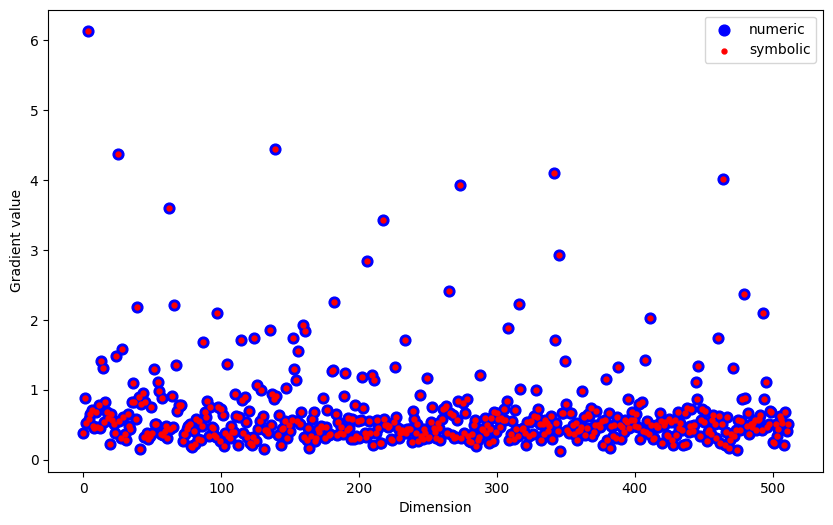

In [10]:
def numericalgradient(fun,w,e):
    # get dimensionality
    d = len(w)
    # initialize numerical derivative
    dh = np.zeros(d)
    # go through dimensions
    for i in range(d):
        # copy the weight vector
        nw = w.copy()
        # perturb dimension i
        nw[i] += e
        # compute loss
        l1, temp = fun(nw)
        # perturb dimension i again
        nw[i] -= 2*e
        # compute loss
        l2, temp = fun(nw)
        # the gradient is the slope of the loss
        dh[i] = (l1 - l2) / (2*e)
    return dh

def checkgrad(fun,w,e):
    # evaluate symbolic gradient from fun()
    loss,dy = fun(w)
    # estimate gradient numerically from fun()
    dh = numericalgradient(fun,w,e)
    
    # ii = dy.argsort()
    ii = np.array([i for i in range(len(dy))])
    
    plt.figure(figsize=(10,6))
    plt.scatter([i for i in range(len(dy))], dh[ii], c='b', marker='o', s=60)
    plt.scatter([i for i in range(len(dy))], dy[ii], c='r', marker='.', s=50)
    plt.xlabel('Dimension')
    plt.ylabel('Gradient value')
    plt.legend(["numeric","symbolic"])
    
    # return the norm of the difference scaled by the norm of the sum
    return np.linalg.norm(dh - dy) / np.linalg.norm(dh + dy)

# set lmbda (λ) arbitrarily
lmbda = 0.1
# dimensionality of the input
_, d = xTr.shape
# evaluate loss on random vector
w = np.random.rand(d)
# the lambda function notation is an inline way to define a function with only a single argument.
ratio = checkgrad(lambda weight: ridge(weight,xTr,yTr,lmbda),w,1e-05)
print("The norm ratio is %.10f." % ratio)

<p>Implement the function <code>adagrad</code> which performs adaptive gradient descent. 
Make sure to include the tolerance variable to stop early if the norm of the gradient is less than the tolerance value (you can use the function <code>np.linalg.norm(x)</code>). When the norm of the gradient is tiny it means that you have arrived at a minimum.  <br>
The first parameter of <code>adagrad</code> is a function which takes a weight vector and returns loss and gradient.
</p>                

In [11]:
def adagrad(func,w,alpha,maxiter,eps,delta=1e-02):
    """
    INPUT:
    func    : function to minimize
              (loss, gradient = func(w))
    w       : d dimensional initial weight vector 
    alpha   : initial gradient descent stepsize (scalar)
    maxiter : maximum amount of iterations (scalar)
    eps     : epsilon value
    delta   : if norm(gradient)<delta, it quits (scalar)

    OUTPUTS:
      
    w      : d dimensional final weight vector
    losses : vector containing loss at each iteration
    """

    losses = np.zeros(maxiter)
    ## fill in your code here
    d = w.shape
    z = 0
    itr = 0

    while np.linalg.norm(w) >= delta and itr < maxiter:
        loss, grad = func(w)
        losses[itr] = loss
        z = z + grad**2
        w = w - alpha * grad / np.sqrt(z + eps)
        itr += 1

    return w, losses


Final loss: 0.580166


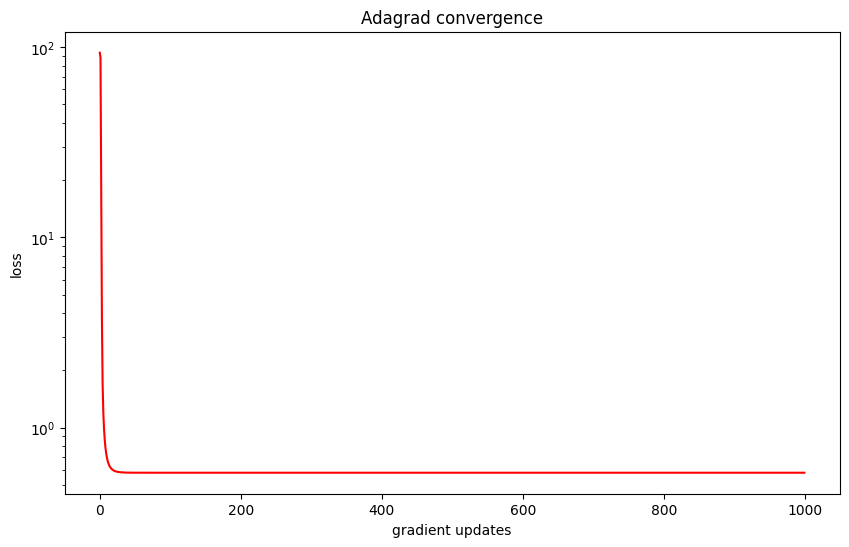

In [12]:
_, d = xTr.shape
eps = 1e-06
w, losses = adagrad(lambda weight: ridge(weight, xTr, yTr, lmbda), np.random.rand(d), 1, 1000, eps)

plt.figure(figsize=(10,6))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("gradient updates")
plt.ylabel("loss")
plt.title("Adagrad convergence")
print("Final loss: %f" % losses[-1])

<p> Write the (almost trivial) function <code>linclassify</code> which returns the predictions for a vector <code>w</code> and a data set <code>xTv</code>. (You can take it from a previous project.)</p>

<p>After this you can check your training and validation accuracy by running the cell below.</p>

In [13]:

def linclassify(w,xTr):
    ## fill in your code here
    res = np.dot(xTr, w )
    print(res)
    hx = np.where(res>0,1,-1)
    return hx

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

[-1.00126399 -0.34499371  0.11080988 ... -0.33001286 -0.60489826
 -0.70393077]
[-0.26688824 -1.30051792 -1.57823673 ... -0.38547179 -1.13796885
 -0.17893127]
Training accuracy 91.48%
Validation accuracy 90.31%



<p>Now implement the two other loss functions, <code>logistic</code> and <code>hinge</code>. Start off with <code>logistic</code>:</p>

In [14]:
def logistic(w,xTr,yTr):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    ## fill in your code here
    loss = np.sum(np.log(1 + np.exp(-yTr * xTr.dot(w))))
    #grad = -(xTr.T * yTr).dot(1 / (1 + np.exp(-yTr * xTr.dot(w)))) + n
    grad = -(xTr.T * yTr).dot(1 / (1 + np.exp(yTr * xTr.dot(w))))
    return loss, grad
    #raise NotImplementedError('Your code goes here!')

<p>You can use the two cells below to test how well this loss function performs.</p>

The norm ratio is 0.0000000004.


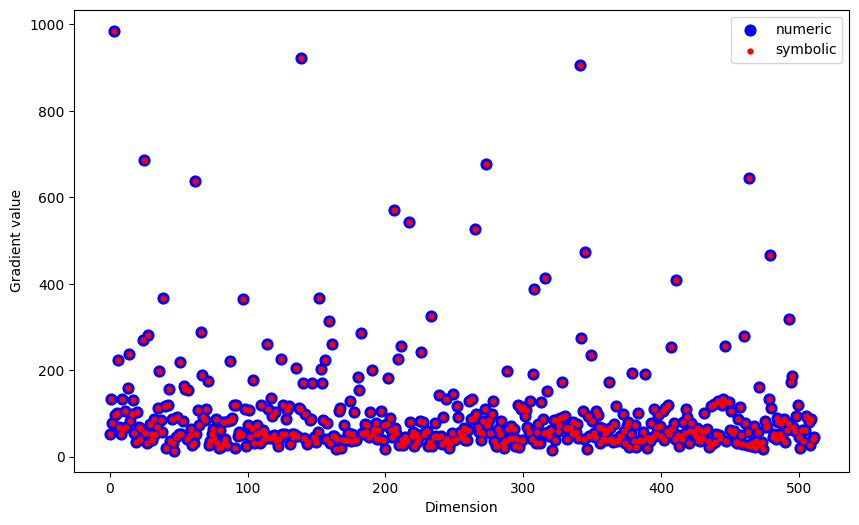

In [15]:
# Gradient sanity check
_, d = xTr.shape
w = np.random.rand(d)
ratio = checkgrad(lambda weight: logistic(weight,xTr,yTr),w,1e-05)
print("The norm ratio is %.10f." % ratio)

In [16]:
w, losses = adagrad(lambda weight: logistic(weight, xTr, yTr), np.random.rand(d), 1, 1000, 1e-06)

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

[-12.91297131  -3.71216856   7.96463864 ...  -2.09157277  -6.45749388
  -4.78373423]
[ -1.87046605 -10.97660939 -34.21534604 ...  -5.88331558 -12.24104591
  -4.85721613]
Training accuracy 95.67%
Validation accuracy 89.59%



<p>Now implement <code>hinge</code>:</p>

In [17]:
#<GRADED>
def hinge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    ## fill in your code here
    loss = np.sum(np.maximum((1 - yTr * xTr.dot(w)), np.zeros(n))) + lmbda * w.dot(w)
    bools = np.argwhere((1 - yTr * xTr.dot(w)) <= 0)
    tmp = yTr.copy()
    tmp[bools] = 0
    grad = 2 * lmbda * w - xTr.T.dot(tmp)

    return loss, grad

<p>You can use the two cells below to test how well this loss function performs.</p>

The norm ratio is 0.0000000004.


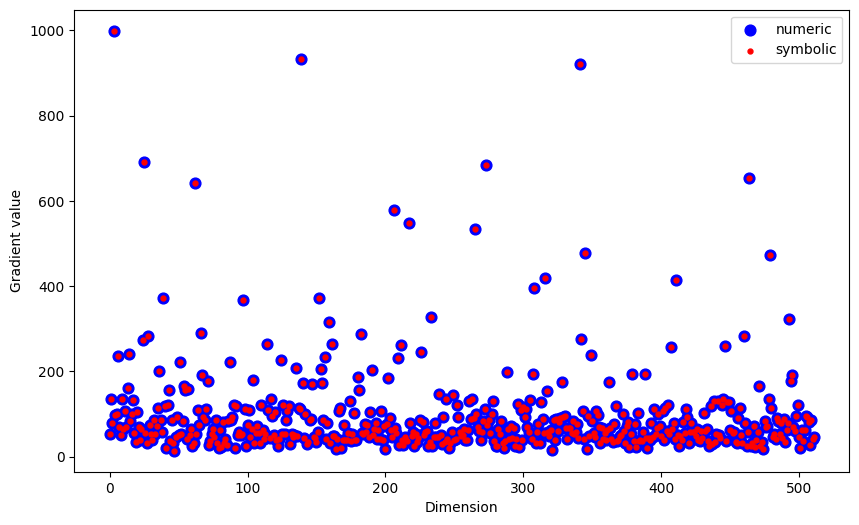

In [18]:
# Gradient sanity check
lmbda = 0.1
_, d = xTr.shape
w = np.random.rand(d)
ratio = checkgrad(lambda weight: hinge(weight,xTr,yTr,lmbda),w,1e-05)
print("The norm ratio is %.10f." % ratio)

In [19]:
w, losses = adagrad(lambda weight: hinge(weight, xTr, yTr, lmbda), np.random.rand(d), 1, 1000, 1e-06)

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

[-8.9343832  -1.13314357  3.73562611 ... -1.12077286 -3.94393717
 -2.29827339]
[  0.70190657  -7.37346899 -16.69935998 ...  -1.78157104  -6.15916178
  -2.6980017 ]
Training accuracy 96.48%
Validation accuracy 89.59%

